# Preliminary Steps

## Imports

In [1]:
from dotenv import load_dotenv

import os

from sql_query_helper_funcs import exec_and_commit_query, sql_query_to_pandas_df

import pandas as pd

from sqlalchemy import create_engine

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm

from scipy import stats

In [2]:
load_dotenv()

True

## Connecting to Local DB

In [3]:
db_user = os.environ.get('USER_NAME')
db_pass = os.environ.get('PASS')
db_ip = os.environ.get('IP_ADDRESS')
db_port = os.environ.get('PORT')
db_name = os.environ.get('DB_NAME')

engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_pass}@{db_ip}:{db_port}/{db_name}')

In [4]:
# This formats numbers in pandas DataFrames to have commas such that numbers
# are more legible.  Example: 214310 -> 214,310
pd.options.display.float_format = '{:,}'.format

# Correlation
The goal here is to answer the following questions:
1.  Is there any correlation between user attributes and points earned?  
2.  If so, can the correlation be quantified in some way?

## Assumptions

1. The correlation we're interested in is between user attributes and yearly points earned.
2. If a userid is found in the users table but not in the event performance table, that's because that userid never participated in a gaming event and thus has scored 0 points for the year.
3. subscriber is binary variable, taking on only values of 0 or 1.
4. category is a nominal categorical variable with only three levels: A, B, or C.  Because category is nominal, there is no ordering to the levels.

## Joining Tables

In [5]:
sql_query = """
WITH total_points_per_user AS (
   SELECT userid
        , SUM(points) AS total_points
     FROM event_performance
 GROUP BY userid
  )

   SELECT u.userid
        , u.subscriber
        , u.category
        , COALESCE(tp.total_points, 0) AS total_points
     FROM users AS u
LEFT JOIN total_points_per_user AS tp
       ON u.userid = tp.userid;
"""

users_attributes_and_tot_points = sql_query_to_pandas_df(sql_query,
                                                         engine)

## Checking Correlation

### Visualizing Correlation

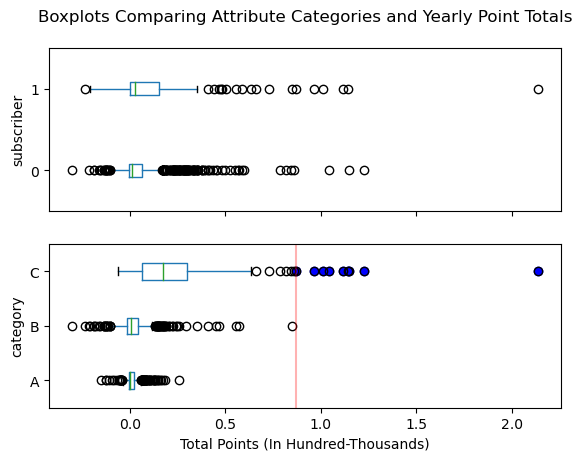

In [6]:
fig, ax = plt.subplots(2, 1, sharex=True)

boxplot1 = users_attributes_and_tot_points.boxplot('total_points', by='subscriber', ax=ax[0], vert=False, return_type='both')
ax[0].set_title(None)
ax[0].grid(None)
ax[0].get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x)/100_000, 2), ',')))

boxplot2 = users_attributes_and_tot_points.boxplot('total_points', by='category', ax=ax[1], vert=False, return_type='both')
ax[1].set_title(None)
ax[1].grid(None)
ax[1].set_xlabel('Total Points (In Hundred-Thousands)')



fig.suptitle('Boxplots Comparing Attribute Categories and Yearly Point Totals')

x = boxplot2[0][-1]['fliers'][2].get_xdata()
y = boxplot2[0][-1]['fliers'][2].get_ydata()
x.sort()
y.sort()
x = x[6:]
y = y[6:]

ax[1].scatter(x, y, color='blue')

ax[1].axvline(x.min(), color='red', linestyle='solid', alpha=0.3);

The first boxplot shows roughly the same spread of point totals regardless of whether a user is a subscriber or not. The medians are close, and the overall distribution of point totals is pretty similar. My initial impression is that there's either no correlation or a weak correlation between whether a user is a subscriber and their yearly point totals.

On the other hand, the second boxplot shows more noticeable differences between the three categories: A, B, and C. Category A and B have fairly similar performance, although category A has a little less variability than category B. However, category C is quite different and is the most interesting.

The plot reveals point totals for category C are skewed right and look to be the strongest performing group.  Very few users in this category have yearly point totals that are negative, and therefore these users must be consistently contributing to the human team's bottom line.

Additionally, category C contains the users with the 9 highest point totals of the year, and it seems unlikely for that to be a coincidence.  This can be seen in the graph, where the red line represents the 9th highest point total of the year.  The nine players who scored at least that many points are represented by the colored circles to the right.

### Subscriber

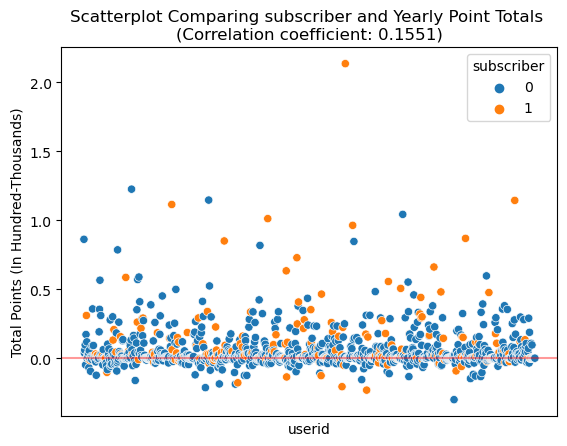

In [7]:
corr=users_attributes_and_tot_points['total_points'].corr(users_attributes_and_tot_points['subscriber'])

ax = sns.scatterplot(x=users_attributes_and_tot_points.index,
                     y='total_points',
                     data=users_attributes_and_tot_points,
                     hue='subscriber')
ax.axhline(y=0, linestyle='solid', color='red', alpha=0.4)
ax.set_xticks([])
ax.set_xlabel('userid')
ax.set_ylabel('Total Points (In Hundred-Thousands)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x)/100_000, 2), ',')))

ax.set_title(f'Scatterplot Comparing subscriber and Yearly Point Totals \n(Correlation coefficient: {corr:.4f})');

Each dot in the scatterplot above represents a unique userid and their yearly point total.  Most dots are clustered together above or below 0, and there doesn't appear to be any noticeable pattern.  Because 81% of users are not subscribers, most of the dots are blue, but there are good amounts of both orange and blue points in the higher point totals, as well as the lower point totals, and there isn't much evidence that one type of user will score much differently from the other.  Everything here confirms what was seen in the box plot earlier: there doesn't seem to be much correlation between whether a user is a subscriber and points earned.  

Since both subscriber and total points are quantitative, Pearson's correlation coefficient can be calculated. The correlation coefficient is 0.1551, indicating a weak correlation; however, this could be true of our sample data and not necessarily true in the greater population.  To check, a t-test must be performed.

In [8]:
X = users_attributes_and_tot_points.loc[:, ['subscriber']]
X = sm.add_constant(X)
y = users_attributes_and_tot_points.loc[:, ['total_points']]

linear_model_subscriber = sm.OLS(y, X).fit()

In [9]:
subscriber_summary_results = linear_model_subscriber.conf_int()

subscriber_summary_results.rename(mapper={0:'95%_conf_int_lower', 
                                          1:'95%_conf_int_upper'}, 
                                  axis=1, inplace=True)

subscriber_summary_results['pvalues'] = linear_model_subscriber.pvalues
subscriber_summary_results['coefficients'] = linear_model_subscriber.params

subscriber_summary_results = subscriber_summary_results[['coefficients', 
                                                         'pvalues', 
                                                         '95%_conf_int_lower', 
                                                         '95%_conf_int_upper']]

round(subscriber_summary_results.loc[['subscriber']], 4)

,coefficients,pvalues,95%_conf_int_lower,95%_conf_int_upper
subscriber,"6,684.8246",0.0,"4,163.9272","9,205.7219"


#### Peforming a t-test

$H_0:$ There is no significant correlation between subscriber and total_points

$H_a:$ There is a significant correlation between subscriber and total_points

At the $\alpha=0.05$ level of significance, the P-value is ~0 and the null hypothesis should be rejected.  This indicates there is sufficient evidence to conclude that subscriber is statistically significant when predicting total points.  

The summary output from above shows that the coefficient for subscriber is 6,684.8246, meaning that on average, someone who has subscriber = 1 will earn 6,684.8246 points more than someone with subscriber = 0.  We are 95% confident that the true increase in points earned for those with subscriber = 1 is between 4,163.9272 and 9,205.7219 points. 

#### Checking Assumptions of Linear Regression to Determine Validity of the Results

In order for the results from linear regression to be valid, four main conditions must be met:
    
1. Linearity: The relationship between X and Y must be linear.
2. Independence of Errors: There is no relationship between the residuals and the fitted (predicted) Y variable.
3. Normality of Errors: The residuals must be approximately normally distributed.
4. Equal Variances: The variance of the residuals is the same across all values of X.

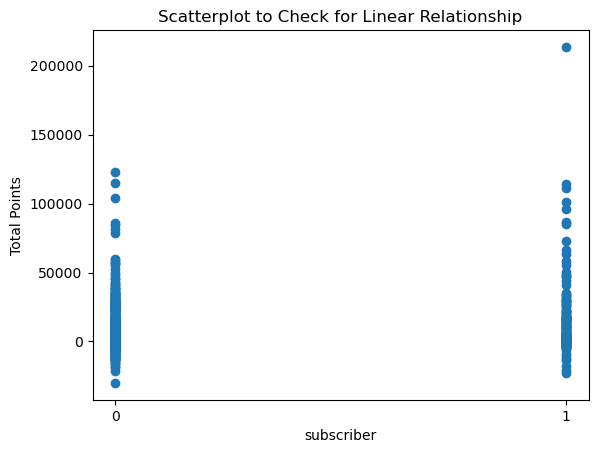

In [10]:
fig, ax = plt.subplots(1,1)

ax.scatter(users_attributes_and_tot_points['subscriber'], 
           users_attributes_and_tot_points['total_points'])

ax.set_title('Scatterplot to Check for Linear Relationship')
ax.set_xlabel('subscriber')
ax.set_xticks([0,1])
ax.set_ylabel('Total Points');

The scatter plot doesn't show any indication that the first assumption is violated.  A linear model could be reasonable for this relationship.

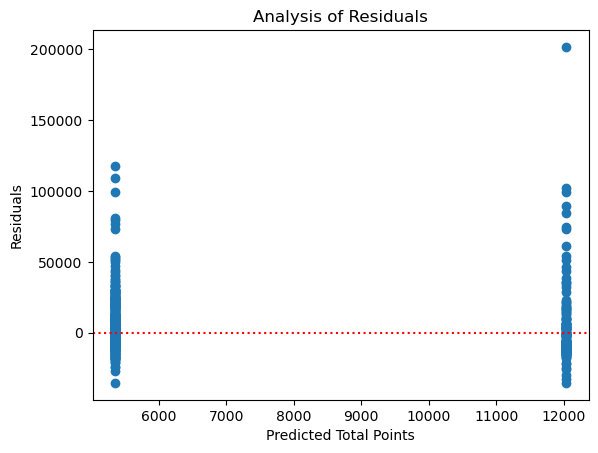

In [11]:
preds = linear_model_subscriber.predict(X)
residuals = users_attributes_and_tot_points['total_points'] - preds

fig, ax = plt.subplots(1,1)

ax.scatter(preds, residuals)
ax.axhline(0, color='red', linestyle=':')
ax.set_xlabel('Predicted Total Points')
ax.set_ylabel('Residuals')
ax.set_title('Analysis of Residuals');

The residual plot doesn't show any indication that the second or fourth assumption is violated.  Because all points are scattered above and below 0, there's no systematic pattern in the residuals and the plot doesn't show any relationship between residuals and total points (second assumption).  Furthermore, the spread across all residuals is roughly the same and therefore the variance of the residuals is roughly the same (fourth assumption).

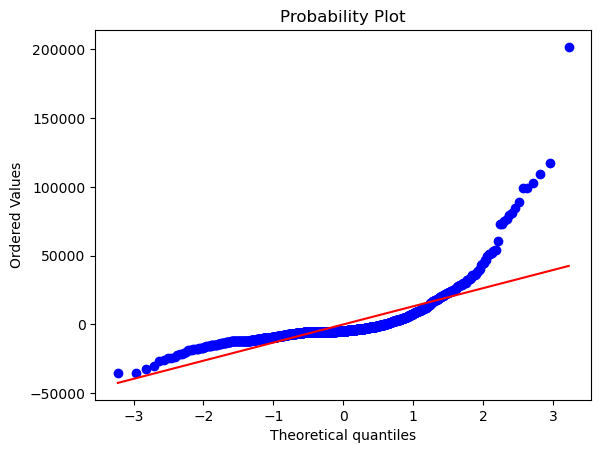

In [12]:
stats.probplot(residuals, plot=plt);

Most of the data points lie close to the straight line; however, there is slight curving, most noticeably on the right side.  This indicates that the residuals may not be normally distributed, which violates the third assumption.

All of the assumptions except for the assumption of normal residuals seem valid, and therefore the conclusion that a correlation exists between subscriber and total points earned is still reasonable, although it should be taken with a grain of salt.

### Category

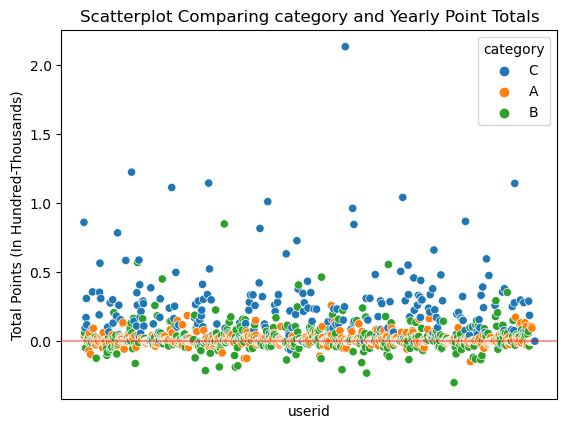

In [13]:
ax = sns.scatterplot(x=users_attributes_and_tot_points.index,
                     y='total_points',
                     data=users_attributes_and_tot_points,
                     hue='category')
ax.axhline(y=0, linestyle='solid', color='red', alpha=0.4)
ax.set_title('Scatterplot Comparing category and Yearly Point Totals')
ax.set_xticks([])
ax.set_xlabel('userid')
ax.set_ylabel('Total Points (In Hundred-Thousands)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x)/100_000, 2), ',')));

Each dot in the scatterplot above represents a unique userid and their yearly point total, which further sheds light on the patterns identified in the box plots from earlier.

Firstly, nearly all users with category = C have positive yearly totals, and these users tend to have the best performance as they're the most common color found in the higher point totals.  Users with category = A are clustered close to 0 and have a tendency to have either slightly above or below 0 total points.  In comparison, most users with category = B are also clustered close to 0, but are a little more spread out and show more variation in point totals.  

Since category is categorical, Pearson's correlation coefficient can't be computed at the moment; however, a One Way ANOVA test can be performed to determine if a correlation exists.

#### Performing a One Way ANOVA test

In [14]:
category_lists = users_attributes_and_tot_points.groupby('category')['total_points'].apply(list)

anova_results = stats.f_oneway(*category_lists)

print(f'P-Value: {anova_results.pvalue:.4f}')

P-Value: 0.0000


$H_0$: category and total yearly points are not correlated

$H_a$: category and total yearly points are correlated

At the $\alpha=0.05$ level of significance, the P-value is ~0 and the null hypothesis should be rejected.  This indicates there is sufficient evidence to conclude that category is correlated with yearly point totals.

One downside to this test is that it doesn't indicate which level(s) of category are most correlated with total points earned; however, we can encode category using dummy variables and check the strength of the correlation that way. 

#### Dummy variables and quantifying correlation

In [15]:
dummy_df = pd.get_dummies(users_attributes_and_tot_points, columns=['category'], dtype=float)

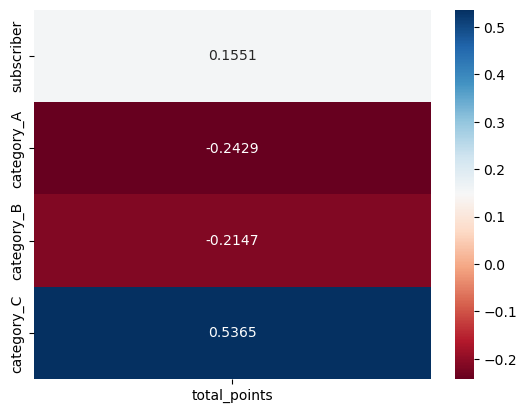

In [16]:
correlations = dummy_df[['subscriber', 'category_A', 'category_B', 'category_C', 'total_points']].corr()

x=correlations[['total_points']][0:4]


sns.heatmap(x, annot=True, cmap='RdBu', fmt='.4g');

A simple heatmap shows that both category A and B have weak/moderate negative correlations with total points earned, -0.24 and -0.21, respectively, although category A is slightly more negatively correlated.  On the other hand, category C has a moderately positive correlation with total points earned of 0.54.

#### Building a Multiple Linear Regression

In [17]:
X = dummy_df.loc[:, ['subscriber', 'category_B', 'category_C']]
X = sm.add_constant(X)
y = dummy_df.loc[:, ['total_points']]

linear_model_all = sm.OLS(y, X).fit()

In [18]:
tbl = linear_model_all.summary2().tables[1]
round(tbl, 4)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,114.4202,703.8912,0.1626,0.8709,"-1,266.7066","1,495.5469"
subscriber,"7,258.8017","1,077.4173",6.7372,0.0,"5,144.768","9,372.8354"
category_B,617.8321,944.3979,0.6542,0.5131,"-1,235.2002","2,470.8643"
category_C,"22,002.3214","1,114.5508",19.741,0.0,"19,815.4269","24,189.2158"


In order to avoid the dummy variable trap, regression has to be performed using all but one level of the dummy variable, which acts as the baseline level for comparison.  In this model, category A represents the baseline level for the dummy variable, and any coefficients of the model must be interpreted relative to that category.

The model will have the following form: $\hat{y} = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3$, where $x_1$, $x_2$, and $x_3$ correspond to the coding scheme:

<ul>
											<li>
												$x_1 = \left\{\begin{aligned} 
													1 &\text{ if userid is a paid subscriber} \\
													0 &\text{ if userid is not a paid subscriber}
												\end{aligned} \right.$
											</li><br>
											<li>
												$x_2 = \left\{\begin{aligned} 
													1 &\text{ if userid is in category B} \\
													0 &\text{ if userid is not in category B}
												\end{aligned} \right.$
											</li><br>
											<li>
												$x_3 = \left\{\begin{aligned} 
													1 &\text{ if userid is in category C} \\
													0 &\text{ if userid is not in category C}
												\end{aligned} \right.$
											</li><br>
										</ul>
                                        
After plugging in the coefficients generated by the summary output, the model looks like this: $\hat{y}=114.4202+7258.8017x_1+617.8321x_2+22002.3214x_3$.

Understanding how to interpret the model will help understand the relationship between user attributes and user performance.  When $x_1, x_2$, and $x_3$ are all set to 0, you have your baseline user, a non-subscriber, who is neither in category B nor in category C; therefore, they must be in category A.  For this kind of user, the model's predicted yearly point total would simply be the constant 114.4202.  

If $x_2$ is set to 1 and all other variables remain 0, then this would represent a non-subscriber in category B.  For this kind of user, the predicted yearly point total would increase by the coefficient of 617.8321 points.  This indicates that, on average, non-subscribers in category B earn 617.8321 points more than non-subscribers in category A.  This echoes what was seen earlier regarding there not being much difference in point scores between users in these categories.

When $x_3$ is set to 1 and all other variables remain 0, the user is a non-subscriber in category C.  For this kind of user, the model would predict a yearly point total of 22,002.314 points higher than the baseline user.  This is the largest coefficient of the model and emphasizes just how strong the performance of users in category C really is.

When $x_1 = 1$, this indicates the user is a subscriber.  Users of any category can be subscribers; therefore, regardless of the values of $x_2$ or $x_3$, $x_1$ could be set to one and "turned on".  Turning on $x_1$ would increase the model's prediction of yearly point totals by its coefficient of 7258.8017, meaning that a subscribing user is predicted to earn that many points more than a non-subscribing user from the same category.  Despite earlier identifying subscriber as having a weak correlation, it produces the second largest effect on predicted yearly point totals in this model and looks to be more important than was initially thought.

## Conclusions

In summary, it seems as though the question of whether there's any correlation between user attributes and user performance has been answered.  Both subscriber and category are statistically significant predictors of a user's performance as measured through their yearly point totals.  The single best predictor is which category a user falls into, with category C being the most important; however, knowing whether a user is a subscriber or not is pretty important too.

# The End